In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from Scripts.Configs.ConfigClass import Config
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split, T_co
from torch_geometric.data.lightning import LightningDataset
import pdb
import lightning as L
# from Scripts.DataManager.GraphConstructor.CoOccurrenceGraphConstructor import CoOccurrenceGraphConstructor

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence\Scripts\Configs\Config.json')

C:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
train_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\train_sm.csv')
test_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\test_sm.csv')

In [3]:
train_df.columns = ['Polarity', 'Title', 'Review']
test_df.columns = ['Polarity', 'Title', 'Review']

In [4]:
train_df = train_df[['Polarity', 'Review']]
test_df = test_df[['Polarity', 'Review']]

In [5]:
my_dict = {1: 'abc', 3: 'aaa'}
if 3 in my_dict:
    print(my_dict[1])

abc


In [6]:
len(train_df['Review'])

50000

In [7]:
#train_df['Review'][:10]

In [8]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence\Scripts\Configs\Config.json')

In [9]:
import time

In [10]:
import os
import pickle
from os import path
from abc import ABC, abstractmethod

import numpy as np
import torch
from torch_geometric.data import Data
from typing import Tuple, Any, List, Dict

from Scripts.Configs.ConfigClass import Config


class GraphConstructor(ABC):

    class _Variables(ABC):
        def __init__(self):
            self.graphs_name: Dict[int, str] = {}
            self.graph_num: int = 0

        def save_to_file(self, filename: str):
            with open(filename, 'wb') as file:
                pickle.dump(self, file)

        @classmethod
        def load_from_file(cls, filename: str):
            with open(filename, 'rb') as file:
                obj = pickle.load(file)
            if isinstance(obj, cls):
                return obj
            else:
                raise ValueError("Invalid file content. Unable to recreate the object.")

    def __init__(self, raw_data, variables: _Variables, save_path: str, config: Config, lazy_construction: bool,
                 load_preprocessed_data: bool, naming_prepend: str = ''):
        self.raw_data = raw_data
        self.config: Config = config
        self.lazy_construction = lazy_construction
        self.load_preprocessed_data = load_preprocessed_data
        self.device = config.device
        self.var = variables
        self.save_path = os.path.join(config.data_root_dir, save_path)
        self.naming_prepend = naming_prepend
        # self.node_attr, self.node_label, self.edge_index, self.edge_attr, self.edge_label = None, None, None, None, None
        # self.data = Data(x=self.node_attr, y=self.node_label, edge_index=self.edge_index)
        self._graphs: Dict[int, Data] = {}

    @abstractmethod
    def to_graph(self, raw_data):
        pass

    def get_graph(self, idx: int):
        if idx not in self._graphs:
            if self.load_preprocessed_data:
                self.load_data(idx)
            else:
                self._graphs[idx] = self.to_graph(self.raw_data[idx])
                self.var.graphs_name[idx] = f'{self.naming_prepend}_{idx}'
        return self._graphs[idx]

    # @abstractmethod
    # def set_graph(self, idx: int):
    #     pass
    #
    # @abstractmethod
    # def set_graphs(self, ids: List | Tuple | range | np.array | torch.Tensor | any):
    #     pass

    def get_graphs(self, ids: List | Tuple | range | np.array | torch.Tensor | any):
        not_loaded_ids = [idx for idx in ids if idx not in self._graphs]
        if len(not_loaded_ids) > 0 and self.load_preprocessed_data:
            self.load_data_list(not_loaded_ids)
        else:
            for idx in not_loaded_ids:
                self._graphs[idx] = self.to_graph(self.raw_data[idx])
                self.var.graphs_name[idx] = f'{self.naming_prepend}_{idx}'
        return {idx:self._graphs[idx] for idx in ids}

    def get_first(self):
        return self._graphs[next(iter(self._graphs))]

    def save_all_data(self):
        for i in range(len(self._graphs)):
            torch.save(self._graphs[i], path.join(self.save_path, f'{self.var.graphs_name[i]}.pt'))
        self.var.save_to_file(path.join(self.save_path, f'{self.naming_prepend}_var.txt'))

    def load_all_data(self):
        self.var = self.var.load_from_file(path.join(self.save_path, f'{self.naming_prepend}_var.txt'))
        for i in range(self.var.graph_num):
            self._graphs[i] = torch.load(path.join(self.save_path, f'{self.var.graphs_name[i]}.pt'))

    def load_var(self):
        self.var = self.var.load_from_file(path.join(self.save_path, f'{self.naming_prepend}_var.txt'))

    def load_data(self, idx: int):
        self._graphs[idx] = torch.load(path.join(self.save_path, f'{self.var.graphs_name[idx]}.pt'))

    def load_data_list(self, ids: List | Tuple | range | np.array | torch.Tensor | any):
        if torch.max(torch.tensor(ids) < self.var.graph_num) == 1:
            print(f'Index is out of range, indices should be more than 0 and less than {self.var.graph_num}')
            return

        for i in ids:
            self._graphs[i] = torch.load(path.join(self.save_path, f'{self.var.graphs_name[i]}.pt'))


In [11]:
import pickle
from typing import List, Dict, Tuple

import pandas as pd
# from Scripts.DataManager.GraphConstructor.GraphConstructor import GraphConstructor
from torch_geometric.data import Data
from Scripts.Configs.ConfigClass import Config
import spacy
import torch
import numpy as np
import os


class CoOccurrenceGraphConstructor(GraphConstructor):

    class _Variables(GraphConstructor._Variables):
        def __init__(self):
            super(CoOccurrenceGraphConstructor._Variables, self).__init__()
            self.nlp_pipeline: str = ''

    def __init__(self, texts: List[str], save_path: str, config: Config,
                 lazy_construction=True, load_preprocessed_data=False, naming_prepend=''):

        super(CoOccurrenceGraphConstructor, self)\
            .__init__(texts, self._Variables(), save_path, config, lazy_construction, load_preprocessed_data,
                      naming_prepend)
        if self.load_preprocessed_data:

            if not self.lazy_construction:
                self.load_all_data()
            else:
                self.load_var()
        else:
            self.var.nlp_pipeline = self.config.spacy.pipeline
            self.var.text_num = len(self.raw_data)
            self.var.graph_num = len(self.raw_data)
            self.nlp = spacy.load(self.var.nlp_pipeline)

            if not self.lazy_construction:
                for i in range(len(self.raw_data)):
                    if i not in self._graphs:
                        if i % 100 == 0:
                            print(f'i: {i}')
                        self._graphs[i] = self.to_graph(self.raw_data[i])
                        self.var.graphs_name[i] = f'{self.naming_prepend}_{i}'
            self.save_all_data()

    def to_graph(self, text: str):
        doc = self.nlp(text)
        unique_words, unique_map = self.__get_unique_words(doc)
        if len(unique_words) < 2:
            return
        unique_word_vectors = self.__get_unique_words_vector(unique_words)
        co_occurrence_matrix = self.__get_co_occurrence_matrix(doc, unique_words, unique_map)
        return self.__create_graph(unique_word_vectors, co_occurrence_matrix)

    @staticmethod
    def __get_unique_words(doc):
        unique_words = []
        unique_map = {}
        for token in doc:
            unique_words.append(token.lower_)
        unique_words = set(unique_words)
        if len(unique_words) < 2:
            return unique_words, unique_map
        unique_words = pd.Series(list(unique_words))
        unique_map = pd.Series(range(len(unique_words)), index=unique_words)
        return unique_words, unique_map

    @staticmethod
    def __get_co_occurrence_matrix(doc, unique_words, unique_map):
        tokens = [t.lower_ for t in doc]
        n_gram = 4
        g_length = doc.__len__() - n_gram
        dense_mat = torch.zeros((len(unique_words), len(unique_words)), dtype=torch.float32)
        for i in range(g_length):
            n_gram_data = list(set(tokens[i:i + n_gram]))
            if len(n_gram_data) < 2:
                continue
            n_gram_ids = unique_map[n_gram_data]
            grid_ids = [(x, y) for x in n_gram_ids for y in n_gram_ids if x != y]
            grid_ids = torch.tensor(grid_ids, dtype=torch.int)
            dense_mat[grid_ids[:, 0], grid_ids[:, 1]] += 1
        dense_mat = torch.nn.functional.normalize(dense_mat)
        sparse_mat = dense_mat.to_sparse_coo()
        return sparse_mat

    def __get_unique_words_vector(self, unique_words):
        unique_word_ids = [self.nlp.vocab.strings[unique_words[i]] for i in range(len(unique_words))]
        unique_word_vectors = torch.zeros((len(unique_words), self.nlp.vocab.vectors_length), dtype=torch.float32)
        for i in range(len(unique_words)):
            word_id = unique_word_ids[i]
            if word_id in self.nlp.vocab.vectors:
                unique_word_vectors[i] = torch.tensor(self.nlp.vocab.vectors[word_id])
            else:
                # Write functionality to resolve word vector ((for now we use random vector)) 1000
                # use pretrain model to generate vector (heavy)
                # Over-fit a smaller model over spacy dictionary
                unique_word_vectors[i] = torch.zeros((self.nlp.vocab.vectors_length,), dtype=torch.float32)
        return unique_word_vectors

    @staticmethod
    def __create_graph(unique_word_vectors, co_occurrence_matrix):  # edge_label
        node_attr = unique_word_vectors
        edge_index = co_occurrence_matrix.indices()
        edge_attr = co_occurrence_matrix.values()
        return Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr)

In [12]:
start_time = time.time()
graph_const = CoOccurrenceGraphConstructor(train_df['Review'], 'AmazonReview', config, lazy_construction=True,  load_preprocessed_data=True, naming_prepend='graph')
print(f'execution time in second: {time.time() - start_time}')
# graph_const = CoOccurrenceGraphConstructor(train_df['Review'][:10], 'AmazonReview', config, lazy_construction=False, naming_prepend='graph', load_preprocessed_data=False)
# graph = graph_const.to_graph(train_df['Review'][0])

execution time in second: 0.0009999275207519531


AttributeError: 'CoOccurrenceGraphConstructor' object has no attribute 'unique_words'

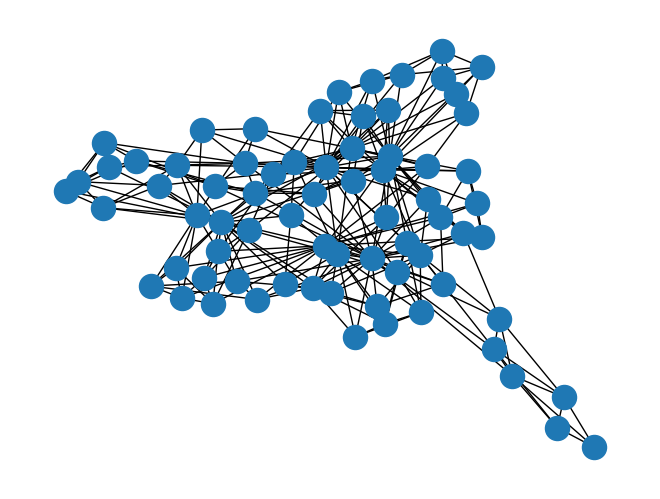

In [14]:
g = to_networkx(graph_const.get_graph(0), to_undirected=True)
layout = nx.spring_layout(g)
nx.draw(g, pos=layout)
unique_words_dict = {i: graph_const.unique_words[i] for i in range(len(graph_const.unique_words))}
nx.draw_networkx_labels(g, pos=layout, labels=unique_words_dict)

In [13]:
len(graph_const.unique_words)

104

In [30]:
# from Scripts.DataManager.GraphLoader.GLabeledGraphLoader import GLabeledGraphLoader

In [31]:
from torch.utils.data import Dataset
from torch_geometric.data import DataListLoader

In [32]:
class GraphConstructorDataset(Dataset):

    def __init__(self, graph_constructor: GraphConstructor, graph_labels):
        self.graph_constructor = graph_constructor
        self.graph_labels = graph_labels

    def __getitem__(self, index):
        x = self.graph_constructor.get_graph(index)
        y = self.graph_labels[index]
        return x, y

    def __len__(self):
        return self.graph_constructor.var.graph_num

In [37]:
from Scripts.DataManager.GraphConstructor.GraphConstructor import GraphConstructor
from Scripts.DataManager.GraphLoader.GraphLoader import GraphLoader
from torch.utils.data.dataset import random_split
import torch
from sklearn.model_selection import train_test_split


class GLabeledGraphLoader(GraphLoader):

    def __init__(self, graph_constructor: GraphConstructor, graph_label, batch_size, device,
                 test_size=0.2, val_size=0.15, *args, **kwargs):
        self.device = device
        self.batch_size = batch_size
        sample_graph = graph_constructor.get_first()
        self.num_node_features = sample_graph.num_features
        self.num_classes = len(torch.unique(graph_label))
        super(GLabeledGraphLoader, self)\
            .__init__(device, test_size, val_size, *args, **kwargs)

        self.dataset = GraphConstructorDataset(graph_const, graph_label)
        self.__train_dataset, self.__val_dataset, self.__test_dataset =\
            random_split(self.dataset , [1-val_size-test_size, val_size, test_size])
        self.__train_dataloader = DataListLoader(self.__train_dataset, batch_size=batch_size, shuffle=True)
        self.__val_dataloader = DataListLoader(self.__val_dataset, batch_size=batch_size, shuffle=True)
        self.__test_dataloader = DataListLoader(self.__test_dataset, batch_size=batch_size, shuffle=True)

    def get_train_data(self):
        return self.__train_dataloader

    def get_test_data(self):
        return  self.__test_dataloader

    def get_val_data(self):
        return self.__val_dataloader


In [39]:
my_data_loader = GLabeledGraphLoader(graph_const, torch.Tensor(train_df['Polarity'][:10]), 64, 'cpu')

C:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_loader = GLabeledGraphLoader(graph_const, train_df['Polarity'], device)

NameError: name 'graph_const' is not defined

In [8]:
[(x,y) for x in range(3) for y in range(3) if x!=y]

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]

In [31]:
aaa = {1: 'a', 2:'vb', 3: 'ds', 4: 'ag'}
ids = np.array([1, 3])
bbb = {idx: aaa[idx] for idx in ids}
print(bbb)

{1: 'a', 3: 'ds'}


In [34]:
for k in bbb:
    print(k)

1
3


In [ ]:

from Scripts.DataManager.GraphConstructor.GraphConstructor import GraphConstructor
from Scripts.DataManager.GraphLoader.GraphLoader import GraphLoader
import torch
from sklearn.model_selection import train_test_split


class GLabeledGraphLoader(GraphLoader):

    def __init__(self, graph_constructor: GraphConstructor, graph_label, batch_size, device,
                 test_size=0.2, val_size=0.15, *args, **kwargs):
        self.device = device
        self.batch_size = batch_size
        self.num_node_features = graph_constructor.get_first().shape[1]
        self.num_classes = len(torch.unique(graph_label))
        super(GLabeledGraphLoader, self)\
            .__init__(device, test_size, val_size, *args, **kwargs)

    def shuffle_train_test(self):
        self.train_indices, self.test_indices = train_test_split(
            torch.concat([self.train_indices, self.test_indices]), test_size=self._test_size)

    def get_train_data(self):
        return self.nodes[self.train_indices], self.node_labels[self.train_indices], self.edge_indices_train

    def get_test_data(self):
        return self.nodes[self.test_indices], self.node_labels[self.test_indices], self.edge_indices_test

    def get_val_data(self):
        return self.nodes[self.val_indices], self.node_labels[self.val_indices], self.edge_indices_val

    def update(self, nodes_x, edge_index, device, *args, **kwargs):
        pass

    def update_edge_index(self, edge_index):
        self.edge_index = edge_index

    def update_nodes(self, nodes_x):
        pass

    def update_node_labels(self, node_y):
        pass

